In [22]:
from IPython.display import HTML

hide_me = ''
HTML('''<script>
code_show=true; 
function code_toggle() {
  if (code_show) {
    $('div.input').each(function(id) {
      el = $(this).find('.cm-variable:first');
      if (id == 0 || el.text() == 'hide_me') {
        $(this).hide();
      }
    });
    $('div.output_prompt').css('opacity', 0);
  } else {
    $('div.input').each(function(id) {
      $(this).show();
    });
    $('div.output_prompt').css('opacity', 1);
  }
  code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input style="opacity:0" type="submit" value="Click here to toggle on/off the raw code."></form>''')

NAMD-QM/MM Tutorial: Advanced Module
====================
Free Energy Profile of Reaction Mechanisms
=======================

<img src="toolkit/3ala_orbital.png" />

In this notebook, you will find a workflow that will help you set up, run and analyse a QM/MM SMD simulation of a reaction mechanism, a String Method optimization of the chosen reaction coordinate, and an eABF calculation of free energy along that optimized string.    
    
We will use a structure and parameters created with VMD following the instructions from the tutorial PDF. If you have not gone through (or can not go through) the PDF and created the initial files, example outputs can be found in the example-output folder, under "OMPDecarb_initial".
    
The notebook is divided in main section for clarity:

0. Notebook setup
1. SMD preparation and execution
2. String Method preparation and execution
3. String Method analysis
4. eABF preparation and execution
5. eABF analysis

Throughout the notebook, we will attempt to explain all aspects of the methods being used, from texts and images explaining the overall processes being executed, to comments in python code being ran in the notebook.

Notebook Setup
====

The following code block loads all modules needed for the entire notebook. Modules can be loaded in every cell, as needed, but aggregating all of them in a single cell at the beginning of the notebook allows us to check if all modules have been installed correctly.

In [23]:
#conda install -c conda-forge ipywidgets
#conda install nodejs
#jupyter labextension install @jupyter-widgets/jupyterlab-manager

import os, sys, shutil, glob, re, subprocess, fileinput
import pandas as pd
import numpy as np
from copy import copy
from collections import OrderedDict
from math import floor
from ipywidgets import widgets
from ipywidgets import interact
from IPython.display import display
import plotnine as p9
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import MDAnalysis

%matplotlib notebook

Set input files, options, and atoms for colvars
--------

In [24]:
pdbFile = "./setup/decarboxylase.0.pdb"
psfFile = "./setup/decarboxylase.0.psf"

#dcdFile = "./SMD_Data/min_smd.dcd"
#xstFile = "./SMD_Data/min_smd.xst"
dcdFile = "./SMD_Data/smd.dcd"
xstFile = "./SMD_Data/smd.xst"

## Calculation options

basePath = "./String_eABF"
setupPath = basePath + "/setup/"
outputPath = basePath + "/output/"

parallelExec = False
sequentialExec = True

stringNumIter = 20
stringNumWalkers = 5
atomDistList = []

eABFWalkersPerImg = 1

eABFnumSteps = 10000

### Decarboxylase

# This list should be built with VMD's 0-based index
atomDistList.append( (3311,3312,"OMP C6 <-> OMP C7") )
atomDistList.append( (3311,1020,"OMP C6 <-> Lys61 HZ1") )
atomDistList.append( (1019,1020,"Lys61 NZ <-> Lys61 HZ1") )
atomDistList.append( (3314,980,"OMP OA <-> Asp59 OD2") )
atomDistList.append( (3313,979,"OMP OB <-> Asp59 OD1") )

atomDistList

[(3311, 3312, 'OMP C6 <-> OMP C7'),
 (3311, 1020, 'OMP C6 <-> Lys61 HZ1'),
 (1019, 1020, 'Lys61 NZ <-> Lys61 HZ1'),
 (3314, 980, 'OMP OA <-> Asp59 OD2'),
 (3313, 979, 'OMP OB <-> Asp59 OD1')]

Set paths for tools used along the tutorial
-----

In [25]:

tempDir = "./tmp"

qmBinPath = "/home/melomcr/Projects_melomcr/Programs/MOPAC_GPU/MOPAC2016.exe"

if sys.platform == 'linux':
    catdcdPath = "catdcd"
    vmdPath = "vmd"
    namdPath = "/Projects/melomcr/NAMD_Gerrit/namd/Linux-x86_64-g++.mpi/namd2"
    
elif sys.platform == 'darwin':
    catdcdPath = "/Applications/VMD\ 1.9.4.app/Contents/vmd/plugins/MACOSXX86/bin/catdcd5.2/catdcd"
    vmdPath = "/Applications/VMD\ 1.9.4.app/Contents/Resources/VMD.app/Contents/MacOS/vmd"

SMD preparation and execution
========

We will now prepare TCL files and call the using VMD in order to combine the files prepared in the first section of this tutorial (provided in the tutorial's PDF file).

# String Method preparation and execution

Calculate colvar values during SMD trajectory
----

We will now use the MDAnalysis module to calculate the values of collective variables along the SMD trajectory. As we direct atoms' movements to induce the chemical reaction, the relevant distances between atom pairs will oscilate and vibrate during the MD simulation.

#### Working with large volumes of data: Pandas


#### Re-arranging data for faster and easier statistics calculation and plotting:  Melt/Cast



In [26]:
%%time

if not os.path.exists(tempDir):
    os.mkdir(tempDir)

numColvars = len(atomDistList)
keyNameDic = { "dist"+str(indx) : str(atomDistList[indx][2]) for indx in range(numColvars) }
    
# Open the PSF and SMD DCD files
u = MDAnalysis.Universe(psfFile,dcdFile)

# Creates atom selection objects
selPairList = []
for cvSel in atomDistList:
    selPairList.append((u.atoms[cvSel[0]], u.atoms[cvSel[1]] ) )

# Initialize the data-frame with standard column names
cvSMD = pd.DataFrame(columns=[ "dist"+str(i) for i in range(numColvars) ])

def calcCV(ts):
    
    return [ np.linalg.norm( selPairList[cvIndx][0].position - selPairList[cvIndx][1].position ) \
         for cvIndx in range(numColvars) ]


# Process trajectory
cvSMD = pd.DataFrame([calcCV(ts) for ts in u.trajectory])
cvSMD.rename(index=str, columns={ cvIndx:"dist" + str(cvIndx) for cvIndx in range(numColvars) }, inplace=True)
cvSMD.reset_index(drop=True, inplace=True)

numFrames = len(cvSMD)

cvSMDMelt = pd.melt(cvSMD, var_name="colvar", value_name="Distance")

CPU times: user 1.28 s, sys: 713 ms, total: 1.99 s
Wall time: 2.12 s


## Select initial string images

*In order to initiate the string optimization, we must choose frames from the trajectory that represent significant steps during the reaction, keeping a good resolution of the chemical process being studied. This process can be tedious and repetitive if done manually, particularly for transformations that can be abrupt and rare. The graphics and tools in the cell below will help analyze colvar values along the trajectory, and select the best frames to initialize the string optimization.*

#### Steps:
- Set the Initial Images value to 4.
- Set an Offset of 150 frames.
- Check the ``Add intermediates`` box and set the maximum delta to *0.6*.
- Click *calculate* (this button should be used every time you change the delta).
    - The *Total Images* should indicate 15 images were created. 
- In the drop down menu, select image number 9 (frame 2413) and delete it (with the minus sign button).
- Select the new image number 9 (now in frame 2415) and change its frame to 2413.

Now we have selected 14 images, and kept the maximum colvar distance to reasonable levels.

VBox(children=(HBox(children=(BoundedIntText(value=10, description='Initial Images:', max=40, min=3, style=DescriptionStyle(description_width='initial')), IntSlider(value=3, max=40, min=3, readout=False), BoundedIntText(value=0, description='Offset:', max=3153, style=DescriptionStyle(description_width='initial')), Button(button_style='danger', description='Reset Selection', icon='eraser', style=ButtonStyle(), tooltip='Resets all selections and allows a new set of evenly spaced images to be created.'))), HBox(children=(ToggleButton(value=False, button_style='info', description='Add Intermediates', icon='square', tooltip='Adds intermediate images in regions of high variability. This will lock the number of evenly spaced images selected above.'), BoundedFloatText(value=0.3, description='Maximum delta:', disabled=True, style=DescriptionStyle(description_width='initial')), ToggleButton(value=True, button_style='info', description='Add last frame', disabled=True, icon='check-square', style=DescriptionStyle(description_width='initial'), tooltip='Add an image at the last step of the simulation.'), Button(button_style='warning', description='calculate', disabled=True, icon='retweet', style=ButtonStyle(), tooltip='(Re)Calculate intermediate images. This may take some time.'))), HBox(children=(Text(value='0', description='Total Images:', disabled=True), Button(icon='plus', style=ButtonStyle(), tooltip='Add Image'), Button(icon='minus', style=ButtonStyle(), tooltip='Remove Image'), Dropdown(description='Image:', options={'Zero': 0}, value=0), BoundedIntText(value=0, description='Frame:', max=3153, style=DescriptionStyle(description_width='initial'))))))

<IPython.core.display.Javascript object>


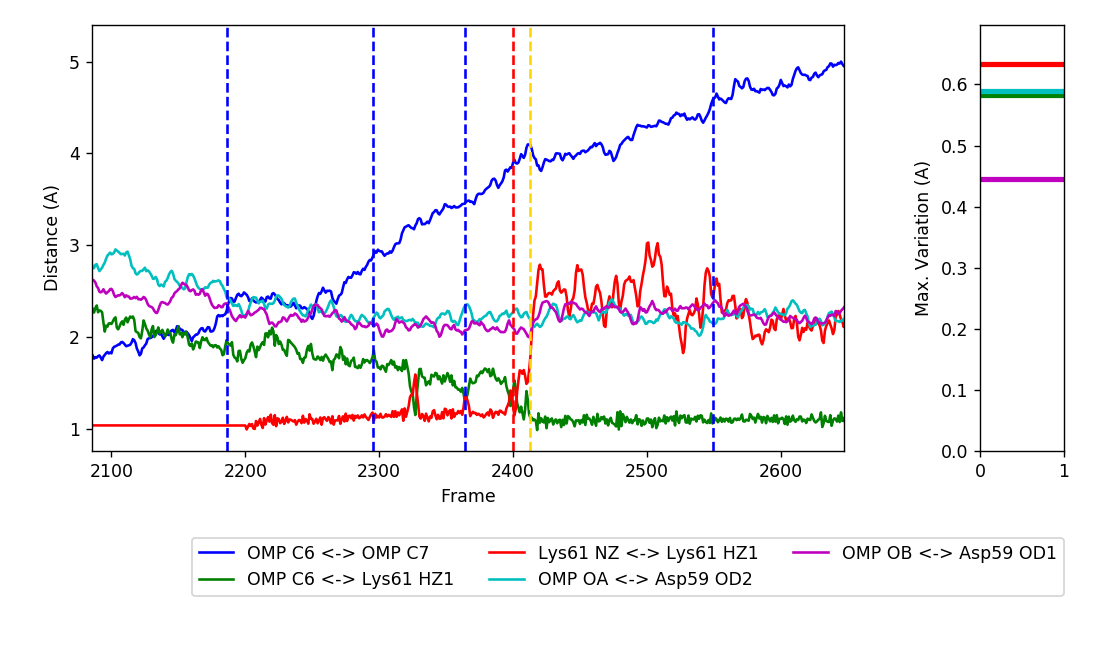

In [27]:
hide_me
%matplotlib notebook

class imageDat:
    ''' Holds data on selected images for String Optimization'''
    
    frame = 0
    ftype = 0
    selected = False
    
    def __init__(self, frame=0, ftype=0, selected=False):
        self.frame = frame
        self.ftype = ftype
        self.selected = selected

allImages = []
numImgs = len(allImages)   # Will initialize as zero
defaultNumImgs = 10

# Sets widgets to select number of images
imagesText = widgets.BoundedIntText(
    value=defaultNumImgs, step=1, min=3, max=40, 
    description="Initial Images:",
    style={'description_width': 'initial'}
)
imagesSlider = widgets.IntSlider(
    value=numImgs, step=1, readout=False, min=3, max=40
)
offsetText = widgets.BoundedIntText(
    value=numImgs, step=1, min=0, max=numFrames,
    description="Offset:",
    style={'description_width': 'initial'}
)
resetSelB = widgets.Button(
    value=False,
    description='Reset Selection',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Resets all selections and allows a new set of evenly spaced images to be created.',
    icon='eraser'
)

mylink = widgets.jslink((imagesText, 'value'), (imagesSlider, 'value'))

hboxImgs = widgets.HBox([imagesText,imagesSlider,offsetText,resetSelB])

# Sets widgets to automatically create images in high variability regions.
activateInterTB = widgets.ToggleButton(
    value=False,
    description='Add Intermediates',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Adds intermediate images in regions of high variability. \
This will lock the number of evenly spaced images selected above.',
    icon='square' # "check-square" vs "square"
)
defaultMaxDelta = 0.3
maxDeltaFT = widgets.BoundedFloatText(
    value=defaultMaxDelta, min=0, 
    description="Maximum delta:",
    style={'description_width': 'initial'},
    disabled=True
)
addLastTB = widgets.ToggleButton(
    value=True,
    description='Add last frame',
    style={'description_width': 'initial'},
    disabled=True,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Add an image at the last step of the simulation.',
    icon='check-square' # "check-square" vs "square"
)
calcInterB = widgets.Button(
    value=False,
    description='calculate',
    disabled=True,
    button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='(Re)Calculate intermediate images. This may take some time.',
    icon='retweet'
)

hboxInter = widgets.HBox([activateInterTB, maxDeltaFT, addLastTB, calcInterB])

# Sets widgets to indicate total number of images
totalImagesText = widgets.Text(
    value='0',
    description='Total Images:',
    disabled=True
)

imgSelect = widgets.Dropdown(
    options={'Zero': 0},
    value=0,
    description='Image:',
)

imgChgFrameText = widgets.BoundedIntText(
    value=0, min=0, max=numFrames,
    description="Frame:",
    style={'description_width': 'initial'}
)

addImg = widgets.Button(
    description='',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Add Image',
    icon='plus'
)

rmImg = widgets.Button(
    description='',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Remove Image',
    icon='minus'
)

hboxFT = widgets.HBox([totalImagesText, addImg, rmImg, imgSelect, imgChgFrameText])

def resetImages(imgCount = defaultNumImgs):
    '''Creates main images. Erases all prior image data.'''
    global allImages, numImgs
    
    if imgCount > 40:
        raise Exception('Too many images!')
    
    offset = offsetText.value
    
    # Initializes number of frames between images as one tenth of total frames, rounding down, and 
    # making sure we have at least 1 (one) frame between images
    imgStride = max(floor( (numFrames-offset)/imgCount ),1)
    allImages = [ imageDat(frame=(x*imgStride) + offset) for x in range(imgCount)]
    numImgs = len(allImages)
    
resetImages()

def toggle_addLast(*args):
    if addLastTB.value:
        addLastTB.icon = "check-square"
    else:
        addLastTB.icon = "square"

addLastTB.observe(toggle_addLast,"value")


# Displays all widgets
ui = widgets.VBox([hboxImgs, hboxInter, hboxFT])
display(ui)

# Build basic plot
xrange = np.arange(0, numFrames, 1)

fig = plt.figure()
gs = gridspec.GridSpec(2, 2, width_ratios=[9, 1], height_ratios=[7,1])
ax = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
lax = plt.subplot(gs[1,:])

ax.set(xlabel='Frame', ylabel='Distance (A)')
ax1.set(xlabel='', ylabel='Max. Variation (A)')
ax1.set_ylim([0,1.5])

plt.show()

colors = ['b','g','r','c','m']
styles = ['-','-.','--',':']
styleTupls = []

def getStyleTupl(i):
    cIndx = i%len(colors)
    sIndx = int(i/len(colors))
    return (colors[cIndx],styles[sIndx])

deltaLines = []
# Populate with selected colvar values
for key, grp in cvSMDMelt.groupby(['colvar']):
    colStyl = getStyleTupl(len(styleTupls))
    styleTupls.append( colStyl )
    ax = grp.plot(ax=ax, kind='line', x=xrange, y='Distance', label=keyNameDic[key], 
                  color=colStyl[0], style=colStyl[1])
    
    # Initializes points used for CV deltas
    deltaLines.append(ax1.axhline(y=0, linewidth=3, 
                                  label=key, color=colStyl[0], linestyle=colStyl[1]) )
    
    plt.draw()

ax.set_xlim([-2,numFrames+2])

h,l = ax.get_legend_handles_labels()
lax.legend(h,l, borderaxespad=0, ncol=3)
lax.axis("off")

ax.legend().set_visible(False)
ax1.legend().set_visible(False)

linesList = []

def setMainImages(*args):
    resetImages(imgCount= imagesText.value)
    update_plot()

imagesText.observe(setMainImages, 'value')

def update_TotImgs(*args):
    global allImages
    totalImagesText.value = str(len(allImages))

imagesText.observe(update_TotImgs, 'value')

# Determines the maximum variation in ColVar values between sequential images.
def find_max_delta(allImages):
    
    numImgs = len(allImages)
    
    maxDeltaCV = [0]*len(cvSMD.columns)
    maxDeltaFrames = [ [0,0] for i in range(len(cvSMD.columns)) ]
    
    for indx in range(1,numImgs):
        
        frameFin = allImages[indx].frame
        frameIni = allImages[indx -1].frame
        
        for colIndx in range(len(cvSMD.columns)):
            
            delta = abs( cvSMD.iloc[frameFin,colIndx] - cvSMD.iloc[frameIni,colIndx] )
            
            if maxDeltaCV[colIndx] < delta:
                maxDeltaCV[colIndx] = delta
                maxDeltaFrames[colIndx][0] = frameIni
                maxDeltaFrames[colIndx][1] = frameFin
    
    return(maxDeltaCV,maxDeltaFrames)

def toggle_reset(*args):
    
    # Resets interface
    imagesText.disabled = False
    imagesSlider.disabled = False
    offsetText.disabled = False
    
    activateInterTB.value = False
    toggle_intermediate()
    
    # Resets user input data
    maxDeltaFT.value = defaultMaxDelta
    imagesText.value = defaultNumImgs
    
    # Resets image selection
    resetImages()
    
    # updates plot
    update_plot()
    update_TotImgs()
    
resetSelB.on_click(toggle_reset)

def update_plot():
    
    global allImages,numImgs, maxDeltaFrames
    
    # Initialize Images on the plot
    
    lineIndx = 0
    for imageObj in allImages:
        
        # We determine the line color
        color = ''
        # Red for main images (equally spaced)
        if imageObj.ftype == 0:
            color = 'r'
        elif imageObj.ftype == 1:
            color = 'g'
        # Blue for interspaced and last frame (if requested)
        else:
            color = 'b'
        
        if imageObj.selected:
            color = 'gold'
        
        # If we can use previously created vertical line objects for the plot, update their values
        if lineIndx < len(linesList):
            linesList[lineIndx].set_xdata(imageObj.frame)
            linesList[lineIndx].set_color(color)
        else:
            # If not, create new vertical lines in the plot.
            linesList.append( ax.axvline(x=imageObj.frame, color=color, linestyle="--") )
        lineIndx += 1
    
    while lineIndx < len(linesList):
        linesList[lineIndx].set_xdata(allImages[0].frame)
        linesList[lineIndx].set_color("r")
        lineIndx += 1
    
    maxDeltaCV,maxDeltaFrames = find_max_delta(allImages)
    
    index = 0
    for delta in maxDeltaCV:
        deltaLines[index].set_ydata(delta)
        index += 1
    
    ax1.set_ylim([0,max(maxDeltaCV)*1.1])
    
    fig.canvas.draw()

def calcIntermediates():
    
    global allImages,numImgs
    
    # Gets current Maximum Delta
    maxD = float(maxDeltaFT.value)
    
    # Clears all intermediate images, and added last frame.
    allImages = [img for img in allImages if img.ftype in [0,1]]
    numImgs = len(allImages)
    
    # Add last frame as main image, if requested.
    if addLastTB.value:
        if (allImages[-1].frame != (len(cvSMD)-1)):
            allImages.append( imageDat(frame=len(cvSMD)-1, ftype=5) )
            numImgs = len(allImages)
    
    interImgs = []
    
    # Loops over all Equally Spaced "gaps"
    for indx in range(1,numImgs):
        
        frameFin = allImages[indx].frame
        frameIni = allImages[indx -1].frame
        
        tmpIni = frameIni
        tmpFin = frameFin
        
        cvCheck = np.asarray([False]*numColvars)
        
        while tmpIni != frameFin:
            
            # Looks for the first cv index that needs to be checked.
            if len(np.where(cvCheck == 0)[0]):
                colIndx = np.where(cvCheck == 0)[0][0]
            else:
                # If all indices are true, update the tmpIni and reset the count.
                cvCheck = np.asarray([False]*numColvars)
                # In this order!
                tmpIni = tmpFin
                tmpFin = frameFin
                
                # If we found a new image, add it to the list
                if tmpIni > frameIni and tmpIni != frameFin:
                    interImgs.append(tmpIni)

            # If the difference in this colvar is less than the maximum,
            # skip to the next.
            tmpdelta = abs( cvSMD.iloc[tmpFin,colIndx] - cvSMD.iloc[tmpIni,colIndx] )
            if tmpdelta <= maxD:
                cvCheck[colIndx] = True
                continue
            
            # Ugly trick to get the first frame, between two images, with a ColVar
            # variation larger than maxD. 
            # R + data.table would do this much more "cleanly", but I'll stop complaining...
            baseVal = cvSMD.iloc[tmpIni,colIndx]
            queryStr = "abs(" + str(baseVal) + "-" + str(cvSMD.columns[colIndx]) + ") >= " + str(maxD)
            indxV = cvSMD.iloc[tmpIni:tmpFin,:].query(queryStr)
            
            # In case there is at least one frame where this ColVar has a variation greater than maxD,
            # we store the frame.
            if len(indxV) > 0 :
                # We also make sure that the image is *after* the initial frame.
                tmpNewFrame = (indxV.index[0] - 1)
                if tmpNewFrame > tmpIni:
                    tmpFin = tmpNewFrame
                    # If we found a new intermeiate image, uncheck all colvars and check the current one.
                    cvCheck = np.asarray([False]*numColvars)
                    cvCheck[colIndx] = True
                    
            else:
                cvCheck[colIndx] = True
    
    # Add new images to the global list
    for frame in interImgs:
        allImages.append( imageDat(frame=frame, ftype=2) )
    
    # Sort all images
    allImages = sorted(allImages, key=lambda x: x.frame)
    numImgs = len(allImages)

def toggle_calcInter(*args):
    calcIntermediates()
    update_plot()

calcInterB.on_click(toggle_calcInter)
calcInterB.on_click(update_TotImgs)

def update_offset(*args):
    '''Call function to reset all initial images using the new value for offset.'''
    resetImages(imagesText.value)
    update_plot()

offsetText.observe(update_offset,'value')

# Connects inputs
def toggle_intermediate(*args):
    # Activate user input
    
    # Change icon and Lock Image Selection.
    if activateInterTB.value:
        activateInterTB.icon = "check-square"
        maxDeltaFT.disabled = False
        addLastTB.disabled = False
        calcInterB.disabled = False
        
        imagesText.disabled = True
        imagesSlider.disabled = True
        offsetText.disabled = True
    else:
        activateInterTB.icon = "square"
        maxDeltaFT.disabled = True
        addLastTB.disabled = True
        calcInterB.disabled = True
        
activateInterTB.observe(toggle_intermediate, "value")

def update_imgSel(*args):
    
    global allImages
    
    optDict = { str(indx) + " (" + str(img.frame) + ")":indx for indx,img in enumerate(allImages) }
    
    imgSelect.options = OrderedDict(sorted(optDict.items(), key=lambda t: t[1]))

totalImagesText.observe(update_imgSel,'value')

def selection_update(*args):
    
    global allImages
    
    imgChgFrameText.value = allImages[ imgSelect.value ].frame
    
    for img in allImages:
        img.selected = False
    allImages[ imgSelect.value ].selected = True
    
    update_plot()

imgSelect.observe(selection_update,'value')

def update_image(*args):
    
    global allImages
    
    newVal = imgChgFrameText.value
    
    if newVal >= numFrames -1 or newVal < 0:
        return
    
    switchOccurred = False
    
    if newVal < allImages[ imgSelect.value ].frame:
        # If there is a next image, we make sure we don't change the order of images
        if imgSelect.value - 1 >= 0:
            if newVal < allImages[ imgSelect.value - 1 ].frame:
                switchOccurred = True
        
    if newVal > allImages[ imgSelect.value ].frame:
        # If there is a next image, we make sure we don't change the order of images
        if imgSelect.value + 1 <= numImgs - 1:
            if newVal > allImages[ imgSelect.value + 1 ].frame:
                switchOccurred = True
    
    allImages[ imgSelect.value ].frame = newVal
    if switchOccurred:
        allImages = sorted(allImages, key=lambda x: x.frame)
        update_imgSel()
        
        for indx,img in enumerate(allImages):
            if img.frame == newVal:
                imgSelect.value = indx
        
        selection_update()
        
    update_plot()

imgChgFrameText.observe(update_image, 'value')

def add_img(*args):
    
    global allImages,numImgs
    
    selectedImg = imgSelect.value
    
    iniFrame = allImages[ selectedImg ].frame
    if selectedImg < numImgs-1:
        finFrame = allImages[ selectedImg + 1 ].frame
    else:
        if iniFrame < numFrames-1:
            finFrame = numFrames-1
        else:
            return
    
    newframe = int(np.floor((iniFrame + finFrame)/2))
    
    if (newframe != iniFrame):
        allImages.append( imageDat(frame=newframe, ftype=1) )
        
        # Sort all images
        allImages = sorted(allImages, key=lambda x: x.frame)
        numImgs = len(allImages)
        
        update_plot()
        update_TotImgs()
        imgSelect.value = selectedImg + 1

addImg.on_click(add_img)

def rm_img(*args):
    
    global allImages,numImgs
    
    selectedImg = imgSelect.value
    
    # If tehre are only three, don't do anyhting or we would get less images than the minimum.
    if numImgs == 3:
        return
    
    # After deleting the image, select the one before it.
    newSel = 0
    if selectedImg == 0:
        newSel = 1
    else:
        newSel = selectedImg -1
    
    # deletes the image
    del allImages[selectedImg]
    
    numImgs = len(allImages)
    
    # Updates widget and plot
    update_plot()
    update_TotImgs()
    imgSelect.value = newSel
    
    
rmImg.on_click(rm_img)
    
update_plot()

update_TotImgs()

plt.tight_layout()

###  2 TABS = all frames (Value vs Frame) + MaxVar | All Images (Value vs Image Index) + Min/Avr/Max Var
### Color backgroud by Max Var ?

In [28]:
print("Frame Offset:",offsetText.value,"; Number of main images:", imagesText.value, ";  Max delta:", maxDeltaFT.value)

Frame Offset: 150 ; Number of main images: 4 ;  Max delta: 0.6


In [29]:
frames = [f.frame for f in allImages]

print("We selected",numImgs,"images:",frames)

We selected 14 images: [150, 395, 512, 900, 1650, 2186, 2295, 2364, 2400, 2413, 2549, 2817, 3068, 3152]


### Create _position_ and _periodic box_ files to initiate String calculation

Now that we have selected the frames from our SMD simulations that will compose the statirng points of the string optimization, we must extract and create the necessary files for the string walkers. Both the COOR (a binary format used by NAMD to set atoms' positions) and the XSC (a text file that indicates to NAMD the size of the periodic box) need to be created for each image.

The following cell has python code that creates the necessary directories for setup and output, and runs the *CATDCD*  software (distributed along with VMD) that specializes in reading and writing MD trajectory files.

In [ ]:
# Erases setup files if they exist. We start from scratch to avoid future errors.
if os.path.exists(basePath):
    shutil.rmtree(basePath)

# Creates setup directory (where coor and xsc files will be written), and base output directory
os.makedirs(setupPath)
os.makedirs(outputPath)

# Creates output directories for each image
if parallelExec:
    numOutFolders = numImgs*stringNumWalkers
elif sequentialExec:
    numOutFolders = numImgs

for i in range(numOutFolders):
    os.makedirs(outputPath + "/" + str(i))

print("Total selected frames:",len(frames))

# Main loop that creates files for each image.
stringFileList = []
stringIndex = 0
for frame in frames:
    
    # Creates a list of DCD files that will be used to write configuration files for the String.
    stringFileList.append("image_"+str(stringIndex)+".coor")
    
    # Writes selected frames to DCD files for String input
    print("Writing frame " + str(frame) + " to file " + stringFileList[-1])
    command = catdcdPath + " -o " + setupPath + stringFileList[-1] + " -otype namdbin -stype psf -s " + psfFile + \
        " -first " + str(frame+1) + " -last " + str(frame+1) + " -dcd " + dcdFile
    process = subprocess.Popen(command, shell=True)
    process.wait()

    # Exact frames from the XST file for String input
    # Each XSC file is a text file with the same header, which we create below.
    sedFile = setupPath + "image_" + str(stringIndex) + ".xsc"
    tmpFile = open(sedFile,"w")
    tmpFile.write("""# NAMD extended system trajectory file
#$LABELS step a_x a_y a_z b_x b_y b_z c_x c_y c_z o_x o_y o_z
""")
    tmpFile.close()
    # Now we get the data from the chosen frame and append it to the file for the current image.
    sedLine = "cat " + xstFile + " | grep -v ^# | sed -n " + str(frame + 1) + "p >> " + sedFile 
    process = subprocess.Popen(sedLine, shell=True)
    process.wait()
    
    stringIndex += 1


### Create _configuration_ files to initiate String calculation

We now create the configuration files needed to initiate all walkers from the string optimization, one file per string image. All files have the same basic syntax, but differ in individual values that describethe collective variables starting points, since each image represents a different point along the chemical reaction being studyed.

First, we create the common block of text for defining colective variables, which will be used in all configuration files, and use python's "format" capability to dynamically insert data for each colvar, in each image.

In [11]:

# In Python's "format" module, every keyword enclosed in curly brackets will be substituted by a value 
#  provided in a dictionary. If the final string needs actual curly brackets, they can be excaped by using 
#  two consecutive brackets.

# Using example values, the block should read:
#    # Human Readable Label - just a comment
#    colvar {
#        name colvar_name
#        distance {
#            group1 {
#                atomNumbers 123
#            }
#            group2 {
#                atomNumbers 456
#            }
#        }
#    }
#
#    harmonic {
#        name bias_name
#        colvars colvar_name
#        centers 1.234
#        forceConstant 0.0
#    }

# Therefore, using keywords for values that will be substituted later, our string variable will read:

colvarBlock = """
# {CVlabel}
colvar {{
    name swarms_atmDist{CVcolIndx}
    distance {{
        group1 {{
            atomNumbers {atmIndx1}
        }}
        group2 {{
            atomNumbers {atmIndx2}
        }}
    }}
}}

harmonic {{
    name bias_swarms_atmDist{CVcolIndx}
    colvars swarms_atmDist{CVcolIndx}
    centers {CVcenter}
    forceConstant 0.0
}}

"""

Second, we run the loop that uses the string we created in the precious cell to write each configuration file, using the colvar values from the SMD frames previously selected.

In [13]:
# Loop over all images.
for imgIndx in range(len(frames)):
    
    # We create one file per image in the string.
    stringFile = open(setupPath + "colvars_" + str(imgIndx) + ".conf",'w')
    
    # Common colvar communication freqeuncy
    stringFile.write("\ncolvarsTrajFrequency 5\n\n")
    
    # Loop over all colvars
    for colIndx in range(len(cvSMD.columns)):
        
        # We aggregate the information for the currently selected colvar and image in a python dictionary.
        currInfo = {}
        currInfo['CVlabel'] = atomDistList[colIndx][2]
        currInfo['CVcolIndx'] = str(colIndx)
        # Convert atom indices from VMD 0-base index to ColVar 1-base index.  
        currInfo['atmIndx1'] = atomDistList[colIndx][0] + 1
        currInfo['atmIndx2'] = atomDistList[colIndx][1] + 1
        # Get colvar value from the selected SMD frame
        currInfo['CVcenter'] = cvSMD.iloc[frames[imgIndx],colIndx]
        
        # Finally, we substitute the values in the common string block and write it to the file.
        # We write one block of text per colvar.
        stringFile.write( colvarBlock.format(**currInfo) )
    
    
    stringFile.close()
######## end-of-loop

### Create _configuration_ file to initiate eABF free energy calculations

We can also create the configuration file needed to initiate all walkers for the eABF free energy calculation. In this case, a single file is needed since no unique values will be written into them. The only information needed are the atom indices for atoms involved in collective variables, and file names that will hold the end results of the string optimization. We have not ran the string simulations yet, but we can decide on file names right now :)

In [15]:
# Path Collective Variables use the RMSD of relevant atoms to describe the reaction coordinate. For that, we need 
# the atom numbers of all atoms involved in colvars we set at the begining of the notebook.
# We can use python's flexibility to create a unique set of atom indices in one line.
# Warning: Computational tricks ahead! Using "list comprehension", we can create a list by calling each colvar
#    (or cv) in atomDistList, select only the frist two items (the 0-based atom indices) and create
#    a set with them shifted to 1-based index. List comprehensions, automatically combine all pairs in a list 
#    (by doing this operation within brackets), and the resulting list of sets is unpacked by placing an '*' in 
#    fornt of it. The unpacked list of sets is used by the 'set.union' operation to create a union of all sets. 

atmsUnion = set.union(*[ set([cv[0]+1,cv[1]+1]) for cv in atomDistList ])

# An equivalent operation that would be easier to read can be found below, but we can take the oportunity to 
# get used to pyhton's toolset, writing 1 line of code instead of 4.
## atmsUnion = set()
## for cv in atomDistList:
##     for atm in [cv[0]+1,cv[1]+1]:
##         atmsUnion.add(atm)

Now that we know the relevant atoms whose positions we must track, we follow a similar approach as the one used for the string configuration files and use easily edditable text blocks to create the final eABF configuration file. This configuration file creates two collective variables that are *scripted*, meaning they are not coded in the colvar module within NAMD, but are calculated from functions provided in a TCL script called **pathCV.tcl**. You can find more inforamtion in the tutorial PDF file that accompanies this notebook. 
Both collective variables use the same set of PDB files that result from the string optimization.

We will configure the eABF simulation to sample only along the 's' variable. This will not give us the best possible estimate, but will be computationally cheaper since we need only sample one dimension. The eABF algorithm will apply forces on the virtual particle in a region only after acquiring 100 samples in that region. We are using multiple walkers initialized along the string to speed up the sampling process. The 'z' colective variable is only used with a harmonic restraint to keep the eABF virtual particle from wandering away from the main path.

In [21]:

# Sets common text block that will be used to set all points along the optimized string. 
# This defines the path that eABF will use to calculate the free energy.
# The list of atoms is common to all points that define the path, so we add it to the common text block now.
allAtmsList = [atom for atom in atmsUnion]
# We need to sort the atom indices! ColVars modules needs ordered indices for RMSD calculation.
allAtmsList.sort()
# Now we create a list of strings, so we can use the "join" method to 
# join all atom numbers with spaces in between, passing a list of strings to the join method.
allAtmsStr = ' '.join([str(atom) for atom in allAtmsList])
pathNodeStr = """
rmsd {{
 atoms {{
   atomNumbers {{ """ + allAtmsStr + """ }}
 }}
 refpositionsfile ./string/string_{imgIndx}.pdb
}}
"""

# Only one configuration file is needed for eABF.
pathCVFile = open(setupPath + "pathCV.conf",'w')

# Common colvar communication freqeuncy
pathCVFile.write("colvarsTrajFrequency 5\n\n")

# Now we set the two collective variables needed for eABF, the path collective variables.

# Colvar 's' defines the position of the simulations along the path.
begCVs = """
colvar {
   name                  s

   width                 0.05
   lowerboundary         0.0
   upperboundary         1.0
   lowerwallconstant     10.0
   upperwallconstant     10.0

   scriptedFunction      pathCVs
   extendedLagrangian    on
   extendedFluctuation   0.01

"""
pathCVFile.write(begCVs)

# Writes all the definitions of points along the path.
for imgIndx in range(len(frames)):
    pathCVFile.write( pathNodeStr.format(**{'imgIndx': imgIndx}) )

# Closes the first colvar block
pathCVFile.write("}\n\n")

# Colvar 'z' defines the distance of the simulations 'perpendicular' to the path.
begCVz = """
colvar {
   name                  z

   width                 0.05
   lowerboundary        -0.5
   upperboundary         1.5

   scriptedFunction      pathCVz
   extendedLagrangian    on
   extendedFluctuation   0.01
"""
pathCVFile.write(begCVz)

# Writes all the definitions of points along the path.
for imgIndx in range(len(frames)):
    pathCVFile.write( pathNodeStr.format(**{'imgIndx': imgIndx}) )

# Closes the second colvar block
pathCVFile.write("}\n\n")

# Writes the configuration for the ABF procedure. We call this "extended"-ABF because the colvars 
# used in the sampling have been configured to use the extended-lagrangian option.
configPathCV = """
abf {
    #colvars s z
    colvars s
    fullSamples 100

    # Multiple-replica ABF
    shared yes
    sharedFreq 5
    
    # CZAR is the default
    #CZARestimator yes
    #writeCZARwindowFile yes
    
}

harmonic {
   colvars               z
   centers               0.0
   forceConstant         0.5
}

"""
pathCVFile.write(configPathCV)

pathCVFile.close()

### Populate the String/eABF work directory with the necessary files.

We now copy essential files from the decarboxylase system (such as PDB, PSF, topology) and configuration files from the 'templates' directory.
Some of files need specific data that is only knwon after we setup our system, decide on parameters, chose images, etc.

In [ ]:

# Get structure data and NAMD parameters
shutil.copy(pdbFile, basePath)
shutil.copy(psfFile, basePath)

shutil.copytree('./setup/toppar', basePath + '/toppar')

# Get TCL code and parameters for String and eABF calculation
for filename in glob.glob('./templates/*'):
    shutil.copy(filename, basePath)

# Create directory in RAM for faster QM calculation and I/O.
# This path is used in the "namd.conf" file.

if sys.platform == 'linux':
    os.makedirs("/dev/shm/NAMD_SM_qmmm", exist_ok=True)

with fileinput.FileInput(basePath + "/namd.conf", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("QMBINPATH", qmBinPath), end='')

with fileinput.FileInput(basePath + "/string_param.conf", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("STRINGITERATIONS", str(stringNumIter)), end='')

with fileinput.FileInput(basePath + "/string_param.conf", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("NUMWALKERS", str(stringNumWalkers)), end='')

if parallelExec:
    eABFWalkersPerImg = stringNumWalkers
elif sequentialExec:
    eABFWalkersPerImg = 1
    
with fileinput.FileInput(basePath + "/eABF.conf", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("EABFSTEPS", str(eABFnumSteps)), end='')

with fileinput.FileInput(basePath + "/eABF.conf", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("EABFWPERIMG", str(eABFWalkersPerImg)), end='')

To visualize any file in the notebook, use the magic (USE quotes arounf the file name):

**%load "file-name"**

To save modifications made to file, *add* the following magic to the top of the cell (DO NOT use quotes around the file name!):

**%%writefile file-name**


### Run the calculation!

For fully parallel calculations in clusters (using multiple nodes), where all walkers from all swarms of all images walk at the same time, use the file *string_parallel.tcl*.
For single-node calculations, where wlakers of a same image walk sequentially, but walkers of different images walk simultaneously, use *string_sequential.tcl*. Warning: The node needs to have at least as many processor cores as there are images in the string.

An example of a command that can be ran in the terminal window would be (if we had 8 images):

__mpirun -n 8 namd2 +replicas 8 string_sequential.tcl +stdout output/%1d/job00.%1d.log__

The following cell is a *bash* cell that can be used to run NAMD. Remember that this process can take **several hours**, and for the purposes of the QM/MM Workshop, we have provided pre-ran files in the *example-output* folder. You can simply copy the pre-ran files to the *String_eABF/output* folder.

If you still wish to proceed, just remove the comment (the *hash* character "#") from the NAMD line bellow.

In [30]:
%%bash -s "$numImgs"  "$namdPath"

echo "Calculating $1 images..."

cd String_eABF/

echo "mpirun -n $1 $2 +replicas $1 string_sequential.tcl +stdout output/%1d/job00.%1d.log"
#mpirun -n $1 $2 +replicas $1 string_sequential.tcl +stdout output/%1d/job00.%1d.log

cd ..

Calculating $numImgs images...
mpirun -n $numImgs $namdPath +replicas $numImgs string_sequential.tcl +stdout output/%1d/job00.%1d.log


### We backup the results just in case...

In [ ]:
backUP = False
if backUP:
    resultsStringDirBase = "Results_String"

    backupList = [dir for dir in glob.glob(resultsStringDirBase + "_*")]

    newBackDir = resultsStringDirBase + "_" + str(len(backupList)+1)
    print("Creating backup in",newBackDir,"... this may take a minute.")
    shutil.copytree(outputPath, newBackDir)



# String Method analysis


After running the string optimization, we will parte each output file in order to get the evolution of the restraints applied by the string method on the atom distances. As the string iterations progress, we will notice that the harmonic restraints are changing very little, which indicates that the method has converged.

In [37]:

# We are looking for the following pattern inside the log file:
# Updating bias_swarms_atmDist1
# colvars:   # centers = { 4.14177 }
    
# First, we compile a Regular Expression to look for the correct format.
# Regular expression are a powerful tool to match patterns in text files that have complex formats.
regexVal = re.compile("^colvars:   # centers = { ([0-9\.]*) }$")
regexName = re.compile("^Updating bias_swarms_atmDist([0-9]*)$")

# Create a Pandas dataframe with systematic column names (so it's easy to access in the future).
cvString = pd.DataFrame(columns=[ "dist"+str(i) for i in range(numColvars) ] + ["Image","Iter"])

# Initialize with colvar values taken from SMD simulation that initiated the String optimization.
for i in range(numImgs):
    cvString.loc[i] = list(cvSMD.iloc[frames[i],:]) + [i, 0]

# Loop over all images
for image in range(numImgs):
    
    if parallelExec:
        foldIndx = image*stringNumWalkers
    else:
        foldIndx = image
    
    logFiles = []
    folderStr = outputPath + str(foldIndx)
    for logFN in glob.iglob(folderStr + "/job*.log"):
        logFiles.append(logFN)
    
    ## Assuming there is only one log file per image, for now.
    fileName = logFiles[0]
    
    # Set temporary variables
    colvarName = ""
    numIterations = 1
    tmpDF = pd.DataFrame()
    
    with open(fileName,'r') as fileHandle:
        print("Processing file",fileName)
        
        for line in fileHandle:
            matchVal = regexVal.match(line.strip())
            matchName = regexName.match(line.strip())
            
            # First we check if the line provides a name for a colvar (the value will follow in the next line)
            if matchName:
                colvarName = line.strip().split(" ")[1]
                cvIndx = matchName.group(1)
            
            # We only consider matching value strings after we match at least one name string.
            if matchVal and colvarName:
                colvarValue = matchVal.group(1)
                
                tmpDF.loc[0,"dist" + str(cvIndx)] = round(float(colvarValue),4)
                
            # After accumulating values for all colvars, append to data frame.
            if len(tmpDF.columns) == numColvars:
                tmpDF.loc[0,"Image"] = image
                tmpDF.loc[0,"Iter"] = numIterations
                
                cvString = cvString.append(tmpDF)
                
                numIterations += 1
                # Resets temporary data frame
                tmpDF = pd.DataFrame()

cvString.reset_index(drop=True, inplace=True)

Processing file ./String_eABF/output/0/job00.0.log
Processing file ./String_eABF/output/1/job00.1.log
Processing file ./String_eABF/output/2/job00.2.log
Processing file ./String_eABF/output/3/job00.3.log
Processing file ./String_eABF/output/4/job00.4.log
Processing file ./String_eABF/output/5/job00.5.log
Processing file ./String_eABF/output/6/job00.6.log
Processing file ./String_eABF/output/7/job00.7.log
Processing file ./String_eABF/output/8/job00.8.log
Processing file ./String_eABF/output/9/job00.9.log
Processing file ./String_eABF/output/10/job00.10.log
Processing file ./String_eABF/output/11/job00.11.log
Processing file ./String_eABF/output/12/job00.12.log
Processing file ./String_eABF/output/13/job00.13.log


Now that the raw data has been read from all output files, we process the data to determine what is the variation of the string harmonic restraint value along the optimization iterations. The value of the restraint for each colvar is compared to the value at the last iteration, so the deviation will approach zero as the optimization progresses.

In [71]:
# Sets the "Image" column in the data frame as an integer instead of float (for better visualization)
cvString["Image"] = cvString["Image"].astype('int', copy=False)
# First, we create a "melt" version of the dataset for easyer analysis and plotting.
cvStringMelt = pd.melt(cvString, id_vars=["Image","Iter"], var_name="colvar", value_name="Distance")

# We create new column names
cols = [ "dist"+str(i) for i in range(numColvars) ]
colsTrg = [ "dist"+str(i)+"Dev" for i in range(numColvars) ]

# Now we define a function that will calculate the deviation of a restraint when compared to the 
# restraint value at the last string iteration. This used groups created by the Pandas DataFrame below. 
def calculate_deviation(group):
    # We use the new column names to hold the deviation values for each colvar.
    group[colsTrg] = abs(group.loc[:, cols] - group.loc[group.Iter==max(group.Iter), cols].values[0])
    return group

# For each Image, apply the function above to calculate the progression of the restraints over all colvars.
cvStat = cvString.groupby(['Image']).apply(calculate_deviation)

# Melts the dataframe for easyer analysis and plotting, saving only the deviations from the final colvar value.
cvStatMelt = pd.melt(cvStat.loc[:,["Image","Iter"] + colsTrg], id_vars=["Image","Iter"], \
                 var_name="colvar", value_name="Deviation")

# Calculates the mean deviation per iteration, for each colvar. The mean is calculated accross all walkers of an image.
cvStat = cvStatMelt.loc[:,cvStatMelt.columns != "Image"].groupby(["Iter","colvar"], as_index=False).mean()
# Similarly, determines the maximum deviation accross all walker of an image.
cvStat['MaxDev'] = cvStatMelt.loc[:,cvStatMelt.columns != "Image"].groupby(["Iter","colvar"], as_index=False).max()['Deviation']

HBox(children=(Label(value='Statistic:'), RadioButtons(options=('Mean Deviation', 'Maximum Deviation'), value='Mean Deviation')))

<IPython.core.display.Javascript object>


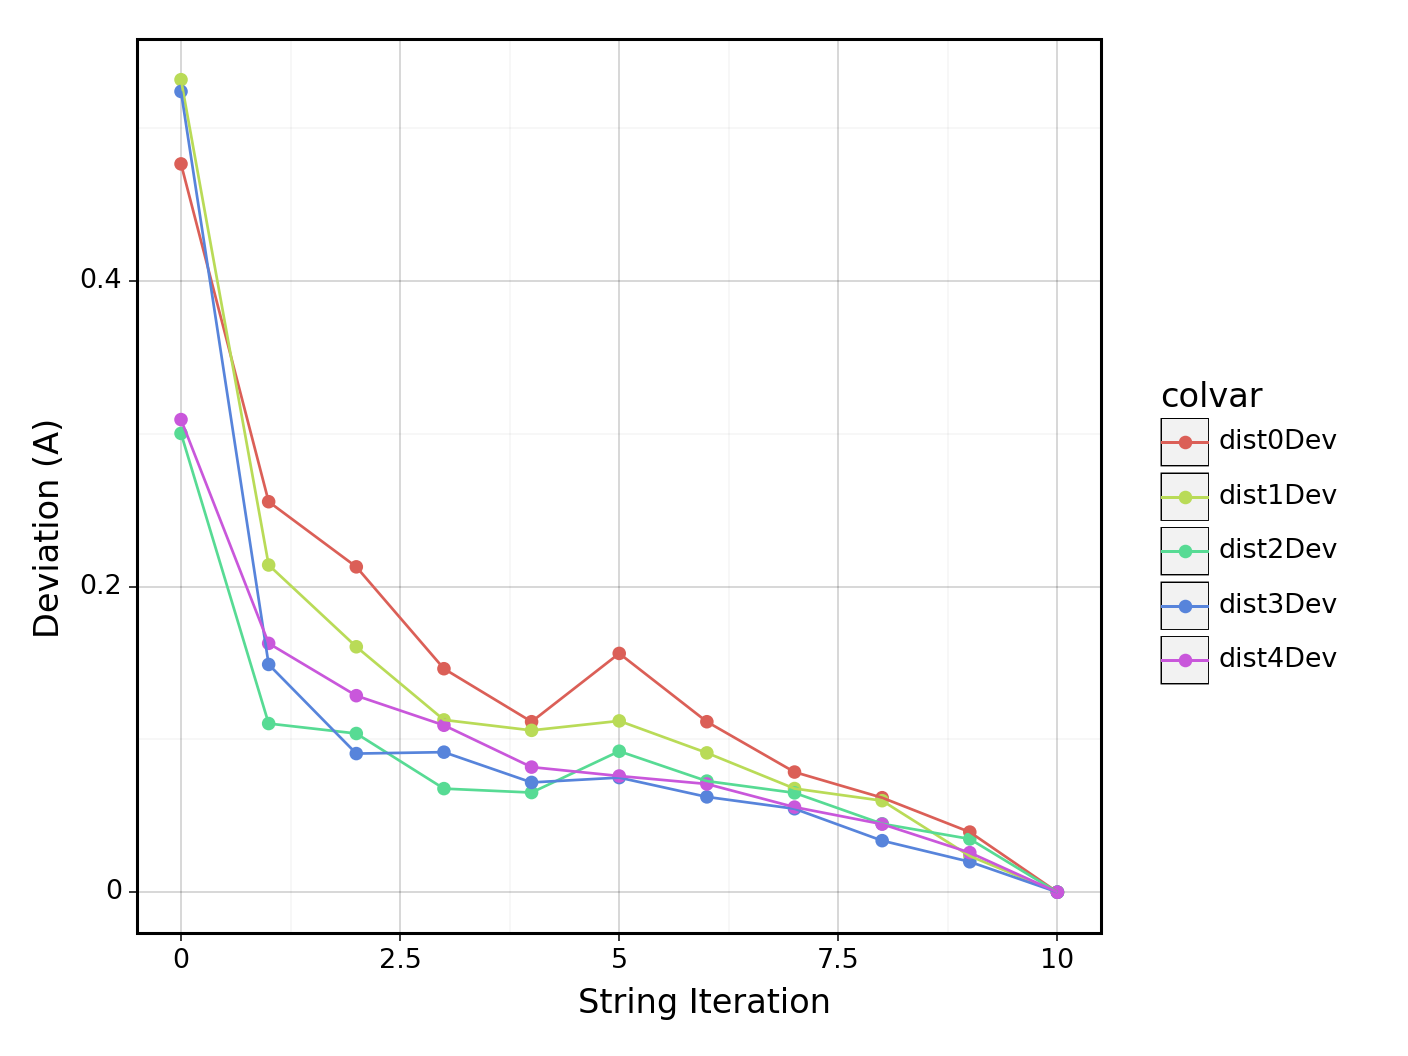

In [42]:
%matplotlib notebook

pd.set_option('mode.chained_assignment',None)

radioStat = widgets.RadioButtons(
    options=['Mean Deviation', 'Maximum Deviation'],
    value='Mean Deviation',
    #description='Pizza topping:',
    disabled=False
)

stringCtl = widgets.HBox([widgets.Label(value="Statistic:"), radioStat])

fig = None
axs = None

def plotString(*args):
    
    global fig, axs
    
    if radioStat.value == "Mean Deviation":
        selStr = 'Deviation'
    else:
        selStr = 'MaxDev'
    
    p = p9.ggplot(cvStat, p9.aes(x="Iter", y=selStr, color="colvar")) + \
        p9.geom_point() + p9.geom_path() + p9.theme_linedraw() + \
        p9.labs(x="String Iteration", y="Deviation (A)")
            
    if fig is None:
        fig, plot = p.draw(return_ggplot=True)
        axs = plot.axs
    else:
        for artist in plt.gca().lines +\
                        plt.gca().collections +\
                        plt.gca().artists + plt.gca().patches + plt.gca().texts:
            artist.remove()
        p._draw_using_figure(fig, axs)
    
radioStat.observe(plotString, 'value')

display(stringCtl)

radioStat.value = 'Maximum Deviation'
plt.tight_layout()

You will notice that the **Mean** deviation is less than 0.2 Angstroms from the 3rd iteration onwards, for all colvars, and the **Maximum** deviation is less than 0.25 A from the 7th iteration onwards.
For a production run, one could require the mean deviation to be less than 0.2 for the last 10 iteration rounds, and the maximum deviation to be less than 0.2 for the last 5, for example, but for the purposes of this tutorial, we will consider this string to be converged "enough".

The following interactive plot will show you the evolution of the constraint values themselves during the string optimization iterations.

HBox(children=(Label(value='Iteration:'), Play(value=1, description='Iterate over the string optimization', interval=1500, max=10), IntSlider(value=1, max=10), ToggleButton(value=False, button_style='info', description='Show Initial Values', tooltip='Shows the initial values of colvars for all images.')))

<IPython.core.display.Javascript object>


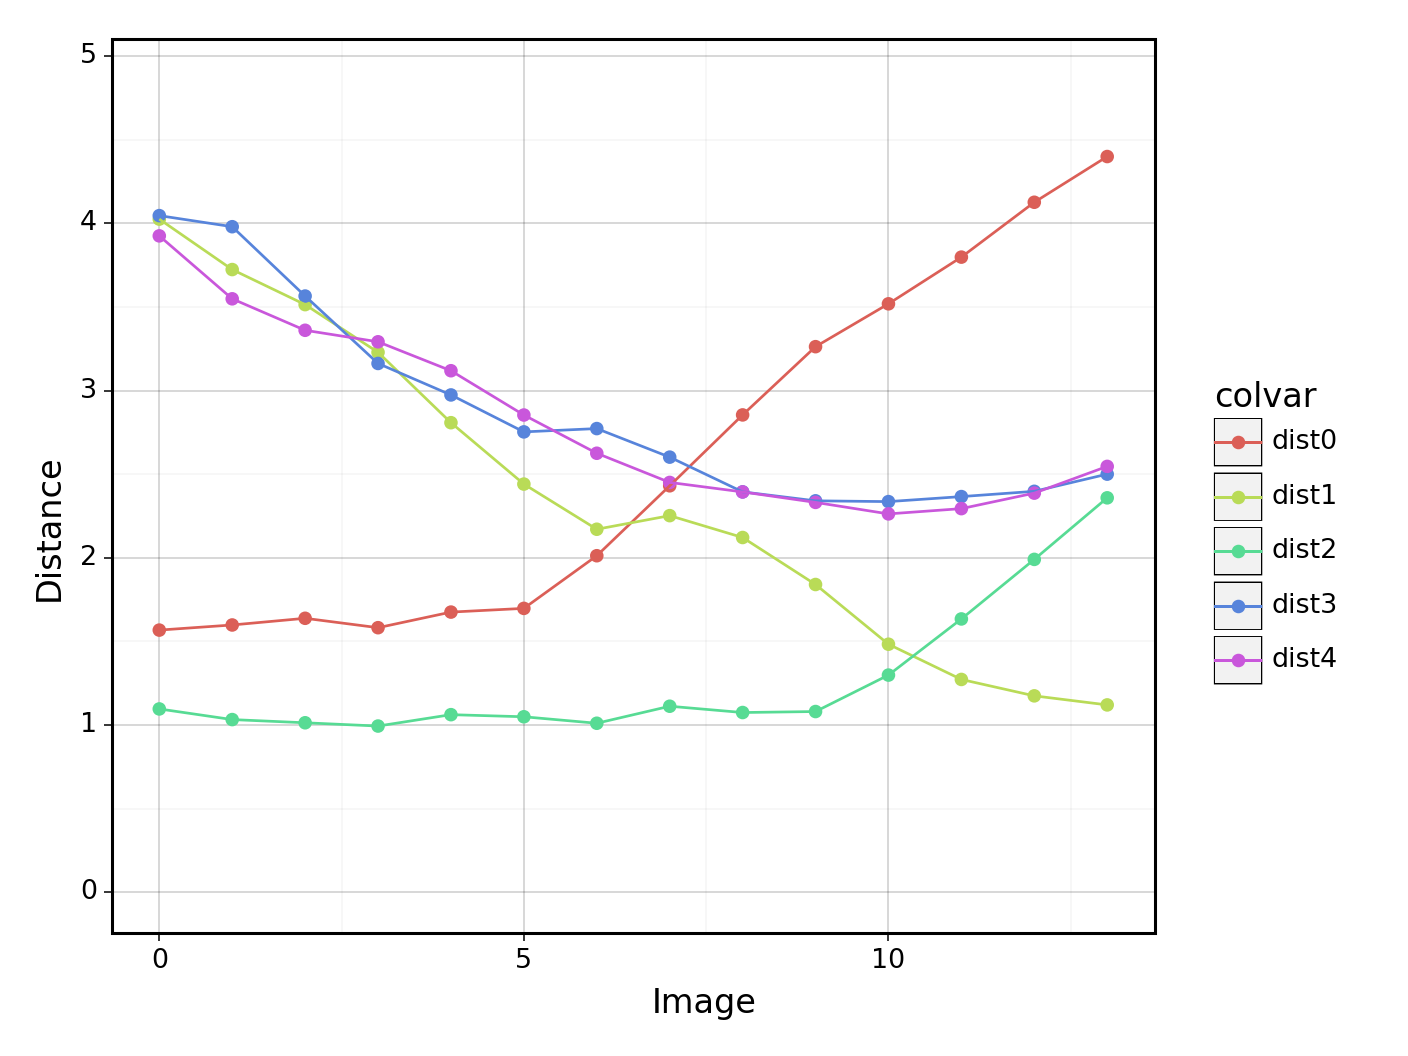

In [57]:
%matplotlib notebook

pd.set_option('mode.chained_assignment',None)

playString  = widgets.Play(
    interval=1500,
    value=1,
    min=0,
    max=numIterations-1,
    step=1,
    description="Iterate over the string optimization",
)

playStringSlider = widgets.IntSlider(value=1, min=0, max=numIterations-1)
widgets.jslink((playString,'value'),(playStringSlider,'value'))

showInitCB = widgets.Checkbox(
    value=False,
    description='Show initial',
    disabled=False
)
showInitTB = widgets.ToggleButton(
    value=False,
    description='Show Initial Values',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Shows the initial values of colvars for all images.',
)

stringCtl = widgets.HBox([widgets.Label(value="Iteration:"), playString, playStringSlider, showInitTB])

maxY = max(cvStringMelt['Distance'])

fig = None
axs = None

def plotString(*args):
    
    global fig, axs
    
    newIter = playStringSlider.value
    #newValue = float(args[0]['new'])
    #print(newValue)
    
    p = p9.ggplot(cvStringMelt.loc[cvStringMelt['Iter'] == newIter,:], \
        p9.aes(x="Image", y='Distance', color="colvar")) + \
        p9.geom_point() + p9.geom_path() + p9.theme_linedraw() + \
        p9.ylim([0,maxY])
    
    if showInitTB.value:
        p += p9.geom_point(cvStringMelt.loc[cvStringMelt['Iter'] == 0,:], \
            p9.aes(x="Image", y='Distance', color="colvar"))
        p += p9.geom_path(cvStringMelt.loc[cvStringMelt['Iter'] == 0,:], \
            p9.aes(x="Image", y='Distance', color="colvar"), linetype="dashed")
            
    if fig is None:
        fig, plot = p.draw(return_ggplot=True)
        axs = plot.axs
    else:
        for artist in plt.gca().lines +\
                        plt.gca().collections +\
                        plt.gca().artists + plt.gca().patches + plt.gca().texts:
            artist.remove()
        p._draw_using_figure(fig, axs)
    
playStringSlider.observe(plotString, 'value')
showInitTB.observe(plotString, 'value')

display(stringCtl)

playStringSlider.value = 0
plt.tight_layout()

You will notice that during the optimization process, the values of the harmonic restraints change, making the string "smoother" over iteraton steps.

The following interactive plot allows a more precise analysis of the progression of the string optimization. Here you can compare the values of colvars plotted on the *X* and *Y* axis.
For chemical reactions, such as the transfer of the Lysine 61 hydrogen atom to the OMP carbon, it is useful to compare two distances: the distance between the hydrogen and the Lysine nitrogen, and the distance between the hydrogen and the OMP carbon. As these distances change, their difference will show the chemical reaction taking place. In our example, the hydrogen from Lysine 61 binds to the carbon that looses the carboxylic group, so the distance between OMP's carbons 6 and 7 is also of interest. By plotting these two measures, we can track the progression of the reaction being studied.

- From the **X-Final** dropdown, select *OMP C6 <-> Lys61 HZ1* 
- From the **X-Initial** dropdown, select *Lys61 NZ <-> Lys61 HZ1*
- From the **Y-Final** dropdown, select *OMP C6 <-> OMP C7*
- From the **Y-Initial** dropdown, select *None*

The images are marked with boxes carrying the image index. In this case (due to this selection of colvars, in this particular order) the plot will show the evolution of of the reaction from the bottom right to the top left. 

HBox(children=(Label(value='Iteration:'), Play(value=1, description='Iterate over the string optimization', interval=1500, max=10), IntSlider(value=1, max=10)))

HBox(children=(Label(value='X-Diff:'), Dropdown(description='X-Final', index=1, options={'OMP C6 <-> OMP C7': 'dist0', 'OMP C6 <-> Lys61 HZ1': 'dist1', 'Lys61 NZ <-> Lys61 HZ1': 'dist2', 'OMP OA <-> Asp59 OD2': 'dist3', 'OMP OB <-> Asp59 OD1': 'dist4'}, value='dist1'), Dropdown(description='X-Initial', options={'OMP C6 <-> OMP C7': 'dist0', 'OMP C6 <-> Lys61 HZ1': 'dist1', 'Lys61 NZ <-> Lys61 HZ1': 'dist2', 'OMP OA <-> Asp59 OD2': 'dist3', 'OMP OB <-> Asp59 OD1': 'dist4', 'None': None}, value='dist0')))

HBox(children=(Label(value='Y-Diff:'), Dropdown(description='Y-Final', index=3, options={'OMP C6 <-> OMP C7': 'dist0', 'OMP C6 <-> Lys61 HZ1': 'dist1', 'Lys61 NZ <-> Lys61 HZ1': 'dist2', 'OMP OA <-> Asp59 OD2': 'dist3', 'OMP OB <-> Asp59 OD1': 'dist4'}, value='dist3'), Dropdown(description='Y-Initial', index=2, options={'OMP C6 <-> OMP C7': 'dist0', 'OMP C6 <-> Lys61 HZ1': 'dist1', 'Lys61 NZ <-> Lys61 HZ1': 'dist2', 'OMP OA <-> Asp59 OD2': 'dist3', 'OMP OB <-> Asp59 OD1': 'dist4', 'None': None}, value='dist2')))

<IPython.core.display.Javascript object>


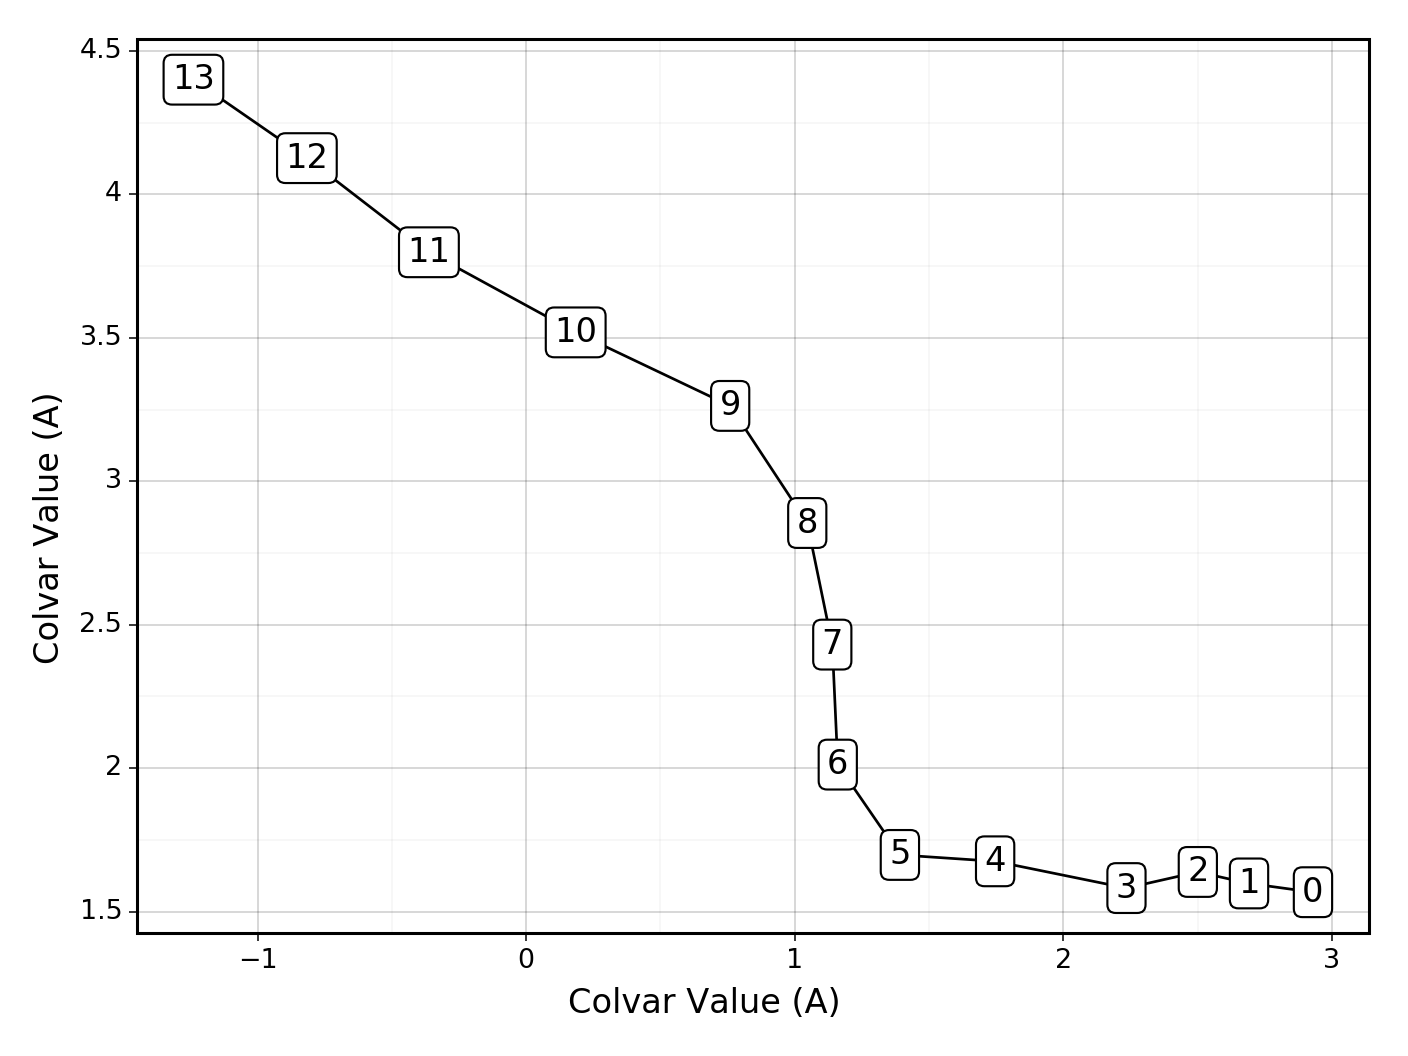

In [73]:
%matplotlib notebook

pd.set_option('mode.chained_assignment',None)

playString  = widgets.Play(
    interval=1500,
    value=1,
    min=0,
    max=numIterations-1,
    step=1,
    description="Iterate over the string optimization",
)

playStringSlider = widgets.IntSlider(value=1, min=0, max=numIterations-1)
widgets.jslink((playString,'value'),(playStringSlider,'value'))

stringCtl = widgets.HBox([widgets.Label(value="Iteration:"),playString, playStringSlider])

# We create an inverse dictionary to populate the drop-down boxes
cvNameKeyDict = { val:key for key,val in keyNameDic.items() }
# And add the option of not chosing 
cvNameKeyDictIni = dict(cvNameKeyDict)
cvNameKeyDictIni.update({'None':None})

selXi = widgets.Dropdown(
    options=cvNameKeyDictIni,
    value='dist0',
    description='X-Initial',
)

selXf = widgets.Dropdown(
    options=cvNameKeyDict,
    value='dist1',
    description='X-Final',
)

dropBoxesX = widgets.HBox([widgets.Label(value="X-Diff:",style={'value_width': 'initial'}),
                          selXf,selXi])

selYi = widgets.Dropdown(
    options=cvNameKeyDictIni,
    value='dist2',
    description='Y-Initial',
)

selYf = widgets.Dropdown(
    options=cvNameKeyDict,
    value='dist3',
    description='Y-Final',
)

dropBoxesY = widgets.HBox([widgets.Label(value="Y-Diff:",style={'value_width': 'initial'}),
                          selYf,selYi])

fig = None
axs = None

def plotString(*args):
    
    global fig, axs
    
    #newValue = float(args[0]['new'])
    #print(newValue)
    newValue = float(playStringSlider.value)
    
    tmpDF = cvString.loc[cvString['Iter'] == newValue,:]
    
    # Verifies we have a selection for difference between colvars. If not, only one colvar value is shown.
    if selXi.value:
        tmpDF['xvals'] = tmpDF[selXf.value] - tmpDF[selXi.value]
    else:
        tmpDF['xvals'] = tmpDF[selXf.value]
    
    if selYi.value:
        tmpDF['yvals'] = tmpDF[selYf.value] - tmpDF[selYi.value]
    else:
        tmpDF['yvals'] = tmpDF[selYf.value]
    
    p = p9.ggplot(tmpDF, p9.aes(x="xvals", y="yvals", label="Image")) + \
        p9.geom_point() + p9.geom_path() + p9.theme_linedraw() +\
        p9.labs(x="Colvar Value (A)", y="Colvar Value (A)") + p9.geom_label()
            
    if fig is None:
        fig, plot = p.draw(return_ggplot=True)
        axs = plot.axs
    else:
        for artist in plt.gca().lines +\
                        plt.gca().collections +\
                        plt.gca().artists + plt.gca().patches + plt.gca().texts:
            artist.remove()
        p._draw_using_figure(fig, axs)
    
playStringSlider.observe(plotString, 'value')

selXf.observe(plotString, "value")
selXi.observe(plotString, "value")
selYf.observe(plotString, "value")
selYi.observe(plotString, "value")

display(stringCtl)
display(dropBoxesX)
display(dropBoxesY)

playStringSlider.value = 0
plt.tight_layout()

In the plot above, the 0 (zero) in the X axis indicates the point where the lysine hydrogen atom is at equal distance from the lysine nitrogen, and the OMP carbon. 
You will notice that, after the string optimization, the final reaction coordinate **first** separates the carbon atoms C6 and C7 (seen by the increased distance between them in the Y axis from image 4 through 8), **and then** transfer the hydrogen atom (seen by the  change in X value, from image 9 to 11).


# eABF preparation and execution

The files for eABF have already been prepared in a previous step. Now, we just create output directories and copy *coordinate* and *periodic box* files from the results of the String Optimization. From the coordinate files, we create PDB files that will define the string path over which multiple ABF walkers will "walk". In order to optimize the sampling, walker are initialized *along* the string, using the optimized string images as starting points, instead of the classical approach where all walkers are initialized at the middle of the string.

In [25]:
# Gets the output path, but removes the last "slash" so a new output directory can be created for the eABF results.
if outputPath[-1] == "/":
    tmpOutputPath = outputPath[0:len(outputPath)-1]

# Creates individual output directories for each eABF walker.
for i in range(numImgs*eABFWalkersPerImg):
    os.makedirs(tmpOutputPath + "_eABF/" + str(i),exist_ok=True)

# Creates the directory where we will place the results of the string optimization.
os.makedirs(basePath + "/string", exist_ok=True)

In [ ]:
#if parallelExec:
#    multiplier = stringNumWalkers
#elif sequentialExec:
#    multiplier = 1
#
## We look for the coordinate output file from the last string iteration.
#r = re.compile('(iter(\d+))')
#
#for image in range(numImgs):
#    dirIndx = image*multiplier
#    
#    print(dirIndx)
#    
#    fileList = glob.glob('./String_eABF/output/' + str(dirIndx) + "/*image*.coor" )
#    filename = sorted(fileList, key=lambda x: int(r.search(x).group(2)) )[-1]
#    
#    print(filename)
    

The following cell is a BASH cell that simply runs two bash scripts that collect the string optimization results, and transforms the final namdbin files into PDB files.

In [26]:
%%bash -s "$numImgs"  "$catdcdPath"

cd String_eABF/

../toolkit/collect-configuration $1 decarb

cd string

../../toolkit/catdcd_coor_to_pdb.sh $1 ../decarboxylase.0.psf $2

cd ../../

---> Job root: decarb
---> 17 images
---> 1 trajectories per image
---> (0/17) collecting output/0/decarb.job0000.image0000.iter0009.coor
---> (1/17) collecting output/1/decarb.job0000.image0001.iter0009.coor
---> (2/17) collecting output/2/decarb.job0000.image0002.iter0009.coor
---> (3/17) collecting output/3/decarb.job0000.image0003.iter0009.coor
---> (4/17) collecting output/4/decarb.job0000.image0004.iter0009.coor
---> (5/17) collecting output/5/decarb.job0000.image0005.iter0009.coor
---> (6/17) collecting output/6/decarb.job0000.image0006.iter0009.coor
---> (7/17) collecting output/7/decarb.job0000.image0007.iter0009.coor
---> (8/17) collecting output/8/decarb.job0000.image0008.iter0009.coor
---> (9/17) collecting output/9/decarb.job0000.image0009.iter0009.coor
---> (10/17) collecting output/10/decarb.job0000.image0010.iter0009.coor
---> (11/17) collecting output/11/decarb.job0000.image0011.iter0009.coor
---> (12/17) collecting output/12/decarb.job0000.image0012.iter0009.coor
--->

### Run eABF simulation

Once more, pre-ran results have been provided in the *example-output* folder. You can copy those results into the *String_eABF/output_eABF* folder and proceed with the analysis.

In [ ]:
%%bash -s "$numImgs"  "$namdPath"

cd String_eABF/

# mpirun -n $1 $2 +replicas $1 eABF.tcl +stdout output_eABF/%1d/job00.%1d.log

After running the simulation with multiple walkers, one must combine all the outputs into one, so that the final calculated PFM is the result of all sampling done by all walkers.
The easiest way to do that is by running a new colculation that takes all previous results as inputs, and then combines them. The following cell runs NAMD with a script (*eABF_combine.tcl*) that has been designed for that.

In [ ]:
%%bash -s "$numImgs"  "$namdPath"

cd String_eABF/

# mpirun -n 1 $2 +replicas 1 eABF_combine.tcl +stdout output_eABF/%1d/job00_combine.%1d.log


# eABF analysis

The following plot combines the colvar transformations with the eABF results, showing how the PMF changes along the reaction coordinate.

In [ ]:
# Read PMF from czar file

In [ ]:
# Plot free energy